# Generative Machine-Learning models

Do you know about fake faces?

<img src="images/gen_faces01.webp" width="700pt"/>

Play here:

 https://www.whichfaceisreal.com/

## Many other data generated by Machine-Learning models:

### Generation

Faces | Manga | Portraits
:-: | :-: | :-:
<img src="images/gen_faces02.gif" width="200pt"/> | <img src="images/gen_manga.gif" width="200pt"/> | <img src="images/einstein.gif" width="300pt"/>

### Super-resolution

<img src="images/SRGAN.webp" width="750pt"/>

### Pixel 2 pixel conversion

<img src="images/pix2pix.png" width="750pt"/>

### Domain adaptation

<img src="images/zebra.gif" width="750pt"/>

### Style-transfer

<img src="images/klimt.gif" width="750pt"/>

### Attribute decomposition/recomposition

<img src="images/ADGAN.gif" width="750pt"/>

### Many more

- images for various targets from scratch or condition;
- videos from text or images;
- music for different instruments/genres;
- voice from text or from scratch;
- text from scratch, from other text (like translation);
- HTML pages, JavaScript code;
- ...

Try plaing with:

https://affinelayer.com/pixsrv/  
https://magenta.tensorflow.org/gansynth

## What is a __generative model__?

> A black-box generating data: $x = f_\theta() \sim \mathcal{X}$

where:

- $\mathcal{X}$ is the data distribution we wish to learn from a given dataset.
- $f$ is a (parametric) function that can sample from $\mathcal{X}$;
- $x$ is a generated sample.

> SPOILER ALERT: Our task is to random sample from a convenience distribution and then transform noise to data:

<img src="images/gen_models_diag_2.svg" width="750pt"/>
<center>See <a href="https://openai.com/blog/generative-models/">OpenAI</a></center>

### Latent variables

Consider a dataset sample $x$ as generated through a process like the following one:

$$\Large p_z \leadsto z \xrightarrow[~f_\theta~]{} \boldsymbol{x} \sim \mathcal{X}$$

> __$z \sim \mathcal{Z}$ are the "causes" explaining the outcome $x$.__

- __generate a feature vector $z$__ (eg. for faces: gender, hair color/style, ethnicity, ...);
 - these features can be hand-chosen or sampled from a distribution $p_z$;
- __generate the sample $x$ from $z$__ as $x = f_\theta(z)$;
 - this is the only visible value, the $z$s are hidden.
 
> Only the variable __$x$ is observerd__.

### Example: hair-saloon spend-per-gender

<img src="https://miro.medium.com/max/1400/1*37aYWR56xVk5GjYMDpu7Ng.png" width="600px"/>
<center>Hair-saloon spend is gender-dependent</center>

Assuming the single gender distribution is a gaussian,  
the population distribution becomes a Mixture of Gaussians (MoG).

$$\Large p_{gender} \leadsto gender \xrightarrow[~f_\theta~]{} \boldsymbol{spend}$$

__PROBLEM__: classify the gender given the hair-saloon spend.

## Discriminative VS generative models

Considering $z$ the latent variable inducing the observable $x$, __by chain rule__:

$$
\{x,z\} \sim p(x,z) = p(z|x)p(x) = p(x|z)p(z)
$$

To face the classification problem we can solve:

- $\hat{z} = \arg\max_z p(z|x) \longrightarrow$ discriminative model;
- $\hat{z} = \arg\max_z p(x|z) \longrightarrow$ generative model.

Let's check the classification problem with both approaches.

#### Example: binary classifier

Consider the case of a binary classification task with two normal-distributed variables:

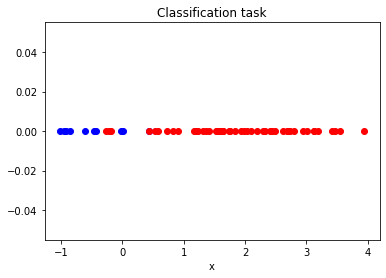

In [26]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import normal as randn

# Unbalanced classification problem:
x1 = randn(size=(10,))/2 - 1
x2 = randn(size=(50,)) + 2
plt.scatter(x1,np.zeros(x1.shape),c='b')
plt.scatter(x2,np.zeros(x2.shape),c='r')
plt.title('Classification task')
plt.xlabel('x')
plt.show();

Discriminative approach: __given the data, what label is most probable__?

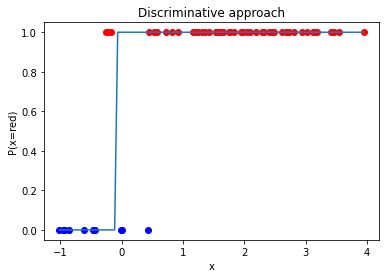

In [27]:
from sklearn.linear_model import LogisticRegression

# Discriminative model:
samples = np.concatenate([x1,x2]).reshape(-1,1)
classification = np.concatenate([np.zeros(x1.shape), np.ones(x2.shape)])
model = LogisticRegression().fit(samples,classification)

plt.scatter(x1,np.zeros(x1.shape),c='b')
plt.scatter(x2,np.ones(x2.shape),c='r')
x = np.linspace(min(samples),max(samples),100)
plt.plot(x,model.predict(x))
plt.title('Discriminative approach')
plt.xlabel('x')
plt.ylabel('P(x=red)')
plt.show()

### Generative models

Consider the maximization problem $\hat{z} = \arg\max_z p(x|z)$.

NOTE: this is __not a probability distribution__, being the free variable $z$ a parameter this is __a function__.

In this case a classifier can work this way:

> Given the label $z$, how much likely are the data $x$?

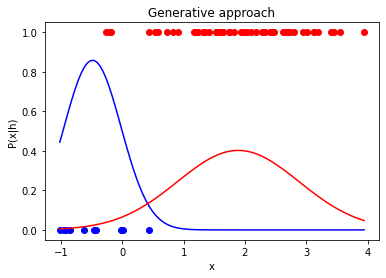

In [30]:
from scipy.stats import norm

# Generative model:
mu1 = x1.mean()
sigma1 = x1.std()
mu2 = x2.mean()
sigma2 = x2.std()

plt.scatter(x1,np.zeros(x1.shape),c='b')
plt.plot(x,norm.pdf(x,mu1,sigma1),c='b')
plt.scatter(x2,np.ones(x2.shape),c='r')
plt.plot(x,norm.pdf(x,mu2,sigma2),c='r')
plt.title('Generative approach')
plt.xlabel('x')
plt.ylabel('P(x|h)')
plt.show()

Notice that the joint probability model:  
$\hat{z} = \arg\max_z p(x,z) = \arg\max_z p(x|z)p(z)$  
takes into account the labels prior too (it is more accurate):

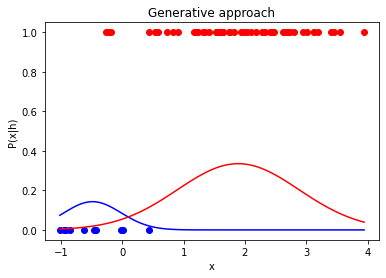

In [32]:
nx1, nx2 = x1.shape[0], x2.shape[0]
tot = nx1 + nx2
px1, px2 = nx1 / tot, nx2 / tot

plt.scatter(x1,np.zeros(x1.shape),c='b')
plt.plot(x,norm.pdf(x,mu1,sigma1)*px1,c='b')
plt.scatter(x2,np.ones(x2.shape),c='r')
plt.plot(x,norm.pdf(x,mu2,sigma2)*px2,c='r')
plt.title('Generative approach')
plt.xlabel('x')
plt.ylabel('P(x|h)')
plt.show()

## Example: direct $p(z|x)$ estimation (discriminative)

Naive Bayes hypothesis: $\large p(z|x)=\prod_i{p(z_i|x)}$

The optimization problem:

$
\large
\begin{eqnarray}
\arg\max_z p(z|x) &=& \arg\max_z \prod_i{p(z_i|x)} \\
&=& \arg\max_z \sum_i\log{p(z_i|x)} \\
\end{eqnarray}
$

We can estimate the (simpler) $p(z_i|x)$ (eg. in tabular form if discrete).

Given an $x$, choose the combination of $z_i$ maximizing $p(z|x)$.

__This approach allows discrimination only__

## Example: maximum likelihood $p(x|z)$ (generative)

PPCA: $\large x = Wz + \mu + \epsilon \qquad \text{where } \epsilon \sim \mathcal{N(0,\sigma)}$

A __stochastic recipe__ to compute $x$ given $z$ is defined by the model.

__This approach allows both discrimination and generation__.

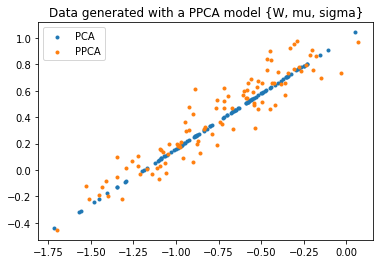

In [50]:
import numpy as np
from numpy.random import normal as randn
from matplotlib import pyplot as plt

sigma = 0.1
alpha = 40*np.pi/180

z = randn(size=(100,))/2 - 1
s,c = np.sin(alpha), np.cos(alpha)
W = np.array([[c],[s]])
mu = np.array([[0,1]]).T

xy = W.dot([z]) + mu
xy2 = W.dot([z]) + mu + randn(scale=sigma, size=xy.shape)

plt.figure()
plt.scatter(xy[0], xy[1], marker='.')
plt.scatter(xy2[0], xy2[1], marker='.')
plt.title('Data generated with a PPCA model {W, mu, sigma}')
plt.legend(['PCA','PPCA'])
plt.show();

## Eigenfaces: generative model (PCA) over face images

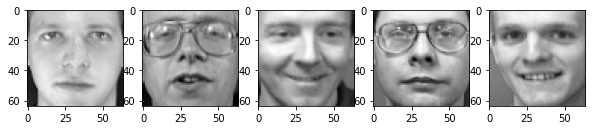

In [74]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load data (from https://github.com/daradecic/Python-Eigenfaces):
faces = pd.read_csv('data/face_data.csv.gz')
faces = faces.drop('target',axis=1)
faces = np.array(faces)


# Showing one face:
def plot_face(*faces):
    plt.figure(figsize=(2*len(faces),2))
    for i, face in enumerate(faces):
        ax = plt.subplot(1,len(faces),i+1)
        plt.imshow(face.reshape(64, 64), cmap='gray')
    plt.show()

plot_face(*faces[0:50:10]);

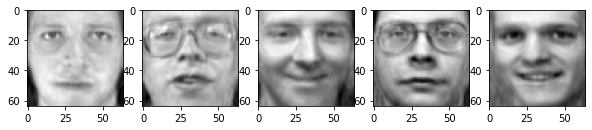

In [92]:
from sklearn.decomposition import PCA

# Number of retained components (max 400):
components = 100

# Computing the PCA of images:
pca = PCA(n_components=components).fit(faces)
latents = pca.transform(faces)

# Reconstructing a face:
def reconstruct_face(*latents):
    return [pca.inverse_transform(latent) for latent in latents]

def plot_reconstructed_face(*latents):
    faces = reconstruct_face(*latents)
    plot_face(*faces)

plot_reconstructed_face(*latents[0:50:10]);

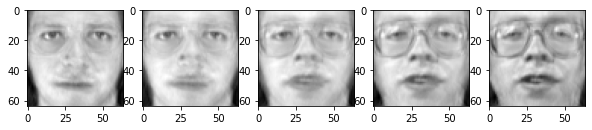

In [113]:
# Interpolation between faces (not different from image inerpolation, in this case):
n = 5
face1, face2 = 0, 10
interpolations = [latents[face1]*(1-alpha) + latents[face2]*alpha for alpha in np.linspace(0,1,n)]
plot_reconstructed_face(*interpolations)

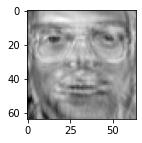

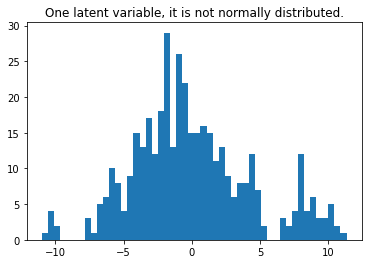

In [115]:
from numpy.random import normal as randn

# Generation of a new face sampling from the normal:
plot_reconstructed_face(randn(size=(1,components)))

# The normality hypothesis is wrong:
plt.hist(latents[:,0],50)
plt.title('One latent variable, it is not normally distributed.')
plt.show();

# The challenge is modeling the right distribution!

## Three generative approaches

<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/three-generative-models.png" width="700"/>
<center><a href="https://lilianweng.github.io/posts/2018-10-13-flow-models/">lilianweng.github.io</a></center>